In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import matplotlib as mpl

from scipy.spatial import cKDTree

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/'

In [46]:
sn000 = arepo.Snapshot(basepath + 'runs/phantom-vacuum-Sg20-Rc3.5/lvl2/output', 80, combineFiles=True)

In [20]:
def compute_T(sn):
    u = sn.part0.InternalEnergy.value
    xe = sn.part0.ElectronAbundance
    
    gamma=5/3
    
    XH = 0.76
    mp = 1.672621911E-24
    mu = 4 * mp / (1 + 3*XH + 4*XH*xe)
    
    kB = 1.381E-16
    
    T = (gamma - 1.) * (u/kB) * 1E10 * mu
    return T

def compute_n(sn):
    rho = np.copy(sn.part0.Density.value)
    xe  = sn.part0.ElectronAbundance
    # print(rho[rho>0])
    
    #convert rho to cgs
    UnitMass   = sn.parameters.UnitMass_in_g
    UnitLength = sn.parameters.UnitLength_in_cm
    rho *= UnitMass/UnitLength**3
    # print(UnitMass/UnitLength**3)
    
    XH = 0.76
    mp = 1.672621911E-24
    mu = 4 * mp / (1 + 3*XH + 4*XH*xe)
    
    # print(np.median(mu))
    # print(np.where(np.isnan(rho[rho>0]))[0])
    # print(rho[:10])
    
    n = rho / mu
    
    return n

In [21]:
T000 = compute_T(sn000)
n000 = compute_n(sn000)
m000 = sn000.part0.mass.value

In [22]:
center = np.array([200, 200, 200])
pos = sn000.part0.pos - center
dens = sn000.part0.rho.value
SFR = sn000.part0.sfr

tree = cKDTree(pos)

In [36]:
nres = 512
from numba import njit

@njit
def create_plot_pos(x, y, nres):
    plot_pos = np.zeros((nres*nres, 3))
    for i in range(len(x)):
        for j in range(len(y)):
            plot_pos[i*nres + j][0]=x[i][0]
            plot_pos[i*nres + j][2]=y[0][j]

    return plot_pos

x, y = np.meshgrid(np.linspace(-15, 15, nres), np.linspace(-15, 15, nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)
# print(plot_pos)

In [37]:
_, key = tree.query(plot_pos)

In [38]:
plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))

plot_SFR = SFR[key]
plot_SFR_map = np.reshape(plot_SFR, (nres, nres))

plot_T = T000[key]
plot_T_map = np.reshape(plot_T, (nres, nres))

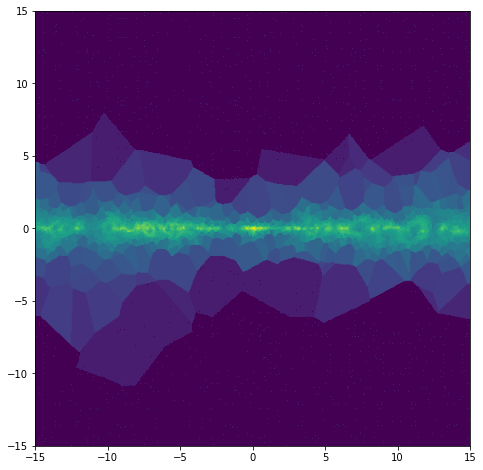

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
extent = [-15, 15, -15, 15]
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
plt.show()

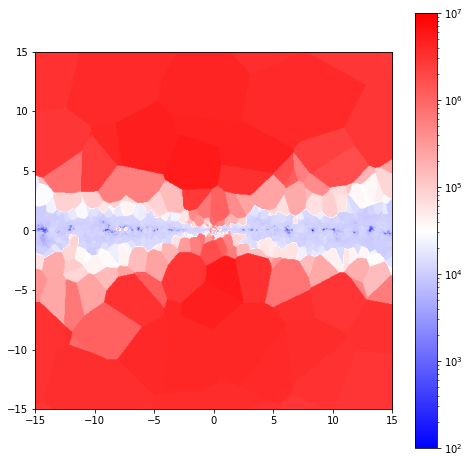

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
extent = [-15, 15, -15, 15]
im=ax.imshow(plot_T_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(vmin=1E2, vmax=1E7), cmap='bwr')
fig.colorbar(im, ax=ax)
plt.show()

[(-6.0, 8.0), (1.0, 7.0)]

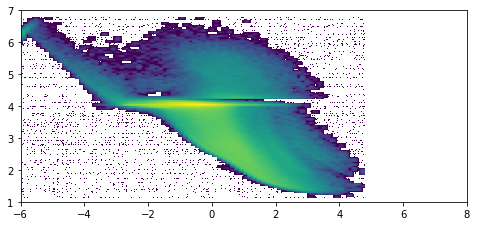

In [45]:
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(np.log10(n000), np.log10(T000), m000, statistic='sum', bins=100)

extent = [x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax.set(xlim=(-6, 8), ylim=(1, 7))
